In [14]:
import math
import numpy as np


r1 = 12*0.01

pvs = []
for i in range(1, 7):
  pv_tmp = 5/math.pow( math.e, r1*0.5*i )
  if i == 6:
    pv_tmp = 105/math.pow( math.e, r1*0.5*i )
  pvs.append(pv_tmp)
print(pvs)
pvs = np.array(pvs)
PV = sum(pvs)
print(PV)
weights = pvs / PV
weights
sum(weights)


[4.708822667921243, 4.434602183585787, 4.17635105705636, 3.933139305332767, 3.7040911034085897, 73.25601423745827]
94.21302055476302


1.0

In [7]:
# read excel files
import pandas as pd
import numpy as np

# file path
file_path = 'Data set Problem 1 China Bond Yield Curve.xlsx'
xlsx = pd.ExcelFile(file_path)
worksheet_names = xlsx.sheet_names
"""
df.shape
['Portfolio',       (6, 12)
 '2020 yield curve',  (4233, 4)
 '2019 yield curve',  (4232, 4)
 '2018 yield curve',  (4032, 4)
 '2017 yield curve',  (4016, 4)
 '2016 yield curve',  (4016, 4)
 '2015 yield curve']  (5229, 4)
"""


# read portfolio
portfolio = pd.read_excel(xlsx, worksheet_names[0])
p_col_names = portfolio.columns


In [8]:
# read yield curve
df = pd.read_excel(xlsx, worksheet_names[1])
col_names = df.columns
# 249 days
dates = [] 
for i in df[col_names[0]]:
  if i not in dates:
    dates.append(i)
dates = np.array(dates)
# 17 terms text
terms_txt = [] 
for i in df[col_names[1]]:
  if i not in terms_txt:
    terms_txt.append(i)
terms_txt = np.array(terms_txt)
# 17 terms converted to year unit
terms = [] 
for i in df[col_names[2]]:
  if i not in terms:
    terms.append(i)
terms = np.array(terms)

terms_txt, terms

(array(['0d', '1m', '2m', '3m', '6m', '9m', '1y', '10y', '15y', '2y',
        '20y', '3y', '30y', '40y', '5y', '50y', '7y'], dtype='<U3'),
 array([ 0.  ,  0.08,  0.17,  0.25,  0.5 ,  0.75,  1.  , 10.  , 15.  ,
         2.  , 20.  ,  3.  , 30.  , 40.  ,  5.  , 50.  ,  7.  ]))

In [9]:
# find interest rates 
# for a bond, its present value:
  # 1. calculate how long from now to end-date/maturity, 1 year = 360 days (convert to year unit)
  # 2. calculate how many coupons remaining, find the interest rate corresponding to that coupon
  # 3. calculate the present value of the bond
    # for example
    # the first bond, 2018/01/18 - 2023/01/18, 5 year
    # on 2020/01/02, there are 3 cash flows
                  # 2020/01/18, coupon, 16/365=0.04 year, r1
                  # 2021/01/18, coupon, 1.04 year, r2
                  # 2022/01/18, coupon, 2.04 year, r3
                  # 2023/01/18, coupon + principle, 3.04 year, r4
    # PV = coupon / e^(r1*0.04) + 
            # coupon / e^(r2*1.04)
            # coupon / e^(r3*2.04)
            # (coupon + principle) * e^(r4*3.04)


import math
def cal_time(end_date, certain_date, payment_number=1):
  end_date = pd.to_datetime(end_date)
  certain_date = pd.to_datetime(certain_date)
  y1, m1, d1 = end_date.year, end_date.month, end_date.day
  y2, m2, d2 = certain_date.year, certain_date.month, certain_date.day
  #
  yd = (y1 - y2) * 360
  dd = (m1*30 + d1) - (m2*30 + d2)
  yn = (yd + dd) / 360
  yn = round(yn, 2)
  flr = math.floor(yn)
  ceil = math.ceil(yn)
  # the dates of cash flows
  cash_flow = []
  if payment_number==1:
    c1 = round(yn-flr, 2)
    num = flr * 1
    cash_flow.append(c1)
    for i in range(1, num+1):
      cash_flow.append(c1 + i)
  elif payment_number==2:
    c1 = yn-flr
    num = flr * 2
    if c1>0.5:
      c1 = c1 - 0.5
      num = num + 1
    c1 = round(c1, 2)
    cash_flow.append(c1)
    for i in range(1, num+1):
      cash_flow.append(c1 + i*0.5)

  return cash_flow

def find_rate(certain_date, cash_flow, df, col_names):
  # all terms & interest rates of a certain day
  tmp = df[ df[col_names[0]] == certain_date ]
  # sort by term 
  tmp = tmp.sort_values(by=[col_names[2]])
  #
  tms = list(tmp[col_names[2]])
  rts = list(tmp[col_names[3]])
  # 
  rates = []
  for ele in cash_flow:
    below = 0
    above = 0
    for i in range(len(tms)):
      if ele<=tms[i]:
        above = i
        below = i-1
        break 
    r = (ele-tms[below])/(tms[above]-tms[below]) * (rts[above]-rts[below]) + rts[below]
    #print( ele, tms[below], tms[above], rts[below], rts[above], r )
    rates.append(r)
  
  return rates

def cal_pv(coupon, principle, cash_flow, rates, payment_number):
  N = len(cash_flow)
  PV = 0
  for i in range(N):
    if i<N-1:
      PV = PV + coupon/payment_number/math.pow( math.e, cash_flow[i]*rates[i]*0.01 )
    else:
      PV = PV + (coupon/payment_number+principle)/math.pow( math.e, cash_flow[i]*rates[i]*0.01 )

  return PV

def cal_pv_update(coupon, principle, cash_flow, rates, payment_number):
  N = len(cash_flow)
  PV = 0
  for i in range(N):
    if i<N-1:
      PV = PV + coupon/payment_number/math.pow( 1+rates[i]*0.01, cash_flow[i] )
    else:
      PV = PV + (coupon/payment_number+principle)/math.pow( 1+rates[i]*0.01, cash_flow[i] )

  return PV


bond_PVs = {}
bond_PVs['date'] = dates
# ------------------------
# get bond
i = 0
for i in range(6):
  start_date = pd.to_datetime( portfolio.loc[i, p_col_names[2]] )  # 起息日期
  year_range = portfolio.loc[i, p_col_names[3]] # 债券期限(年)\n\n[单位] 年
  interest_rate = portfolio.loc[i, p_col_names[5]] # 票面利率(发行时)\n\n[单位] %↓
  end_date = pd.to_datetime( portfolio.loc[i, p_col_names[9]] ) # 到期日期
  payment_number = portfolio.loc[i, p_col_names[10]] # 每年付息次数
  principle = portfolio.loc[i, p_col_names[11]] # 本金金额 （百万）
  coupon = interest_rate * principle * 0.01

  start_date, year_range, interest_rate, end_date, payment_number, principle, coupon

  # calculate the PV of this bond
  iname = portfolio.loc[i, p_col_names[0]]
  bond_PVs[ iname ] = []
  n=0
  for n in range(249):
    certain_date = dates[n]
    cf = cal_time(end_date, certain_date, payment_number)
    rs = find_rate(certain_date, cf, df, col_names)
    #pv = cal_pv(coupon, principle, cf, rs, payment_number)
    pv = cal_pv_update(coupon, principle, cf, rs, payment_number)
    #print('bond ', i, '\t', certain_date, '\t', pv)
    bond_PVs[iname].append(pv)

bond_PVs = pd.DataFrame.from_dict(bond_PVs)
bond_PVs['value'] = bond_PVs[bond_PVs.columns[1]] + bond_PVs[bond_PVs.columns[2]] + bond_PVs[bond_PVs.columns[3]] + bond_PVs[bond_PVs.columns[4]] + bond_PVs[bond_PVs.columns[5]] + bond_PVs[bond_PVs.columns[6]]

In [11]:
bond_PVs

bond_PVs.to_csv('portfolio_values.csv')

In [3]:
import math
math.pow( (1+1.3*0.01), 0.04 )

1.0005167824967494

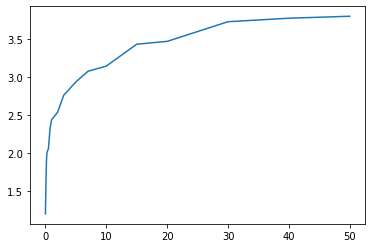

In [99]:
date_num = 1

# all terms & interest rates of a certain day
date_time = dates[date_num]
tmp = df[ df[col_names[0]] == date_time ]
# sort by term 
tmp = tmp.sort_values(by=[col_names[2]])
tmp
  # draw them as line-graph
import matplotlib.pyplot as plt
xv = list(tmp[col_names[2]])
yv = list(tmp[col_names[3]])
plt.plot(xv, yv)
# plt.axis([0, 50, 0, 5])
plt.show()

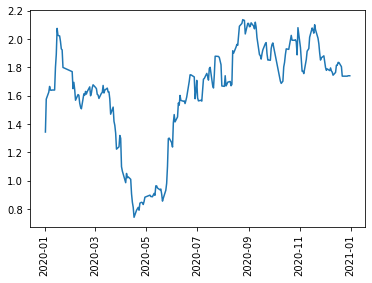

In [96]:
# get a certain term by all days
term_name = terms_txt[1]
tmp = df[ df[col_names[1]] == term_name ]
  # draw them as line-graph
import matplotlib.pyplot as plt
xv = pd.to_datetime(tmp[col_names[0]])
yv = tmp[col_names[3]]
plt.plot(xv, yv)
# plt.axis([0, 50, 0, 5])
plt.xticks(rotation=90)
plt.show()

In [1]:
import time
!pip install ccxt
import ccxt
from time import gmtime, strftime
import datetime
import pandas as pd
print(ccxt.exchanges)

     |████████████████████████████████| 2.1MB 12.1MB/s 
     |████████████████████████████████| 1.3MB 46.5MB/s 
     |████████████████████████████████| 163kB 48.7MB/s 
     |████████████████████████████████| 3.2MB 44.3MB/s 
     |████████████████████████████████| 143kB 49.1MB/s 
     |████████████████████████████████| 235kB 41.3MB/s 
  Created wheel for yarl: filename=yarl-1.1.0-cp37-cp37m-linux_x86_64.whl size=241454 sha256=edd937b00fdd2fa8289014085abd9600abee696c1423ecf0a04ef6421de61322
  Stored in directory: /root/.cache/pip/wheels/96/26/b9/7972042a1a69556ba7f38b8a301dc3a9ddac1b8f61f02fbfd8
Successfully built yarl
['aax', 'aofex', 'ascendex', 'bequant', 'bibox', 'bigone', 'binance', 'binanceus', 'bit2c', 'bitbank', 'bitbay', 'bitcoincom', 'bitfinex', 'bitfinex2', 'bitflyer', 'bitforex', 'bitget', 'bithumb', 'bitkk', 'bitmart', 'bitmex', 'bitpanda', 'bitso', 'bitstamp', 'bitstamp1', 'bittrex', 'bitvavo', 'bitz', 'bl3p', 'bleutrade', 'braziliex', 'btcalpha', 'btcbox', 'btcmarkets', 'b

In [60]:
# We define a function to get the bar from one currency to another. 
# We get at most 3000 data each time due to the exchange's transmision length limitation.
def get_bar_from_to(ex,symbol,period,start_time='2017-08-17 00:00:00',end_time='2021-03-05 23:59:59',length=30000,maxLoop=20):
  data = []
  stime = ex.parse8601(start_time) # ISO8601 is the format of time
  etime = ex.parse8601(end_time)
  loop_i = 0
  if ex.has['fetchOHLCV']:
    while stime < etime and loop_i < maxLoop:
      loop_i += 1
      try:
        ohlcvs = ex.fetch_ohlcv(symbol, period, stime, limit=length)
        #print(ex.iso8601(ex.milliseconds()),'loop_i=',loop_i, ' ,Fetched', len(ohlcvs), 'candles')
        if len(ohlcvs) > 1:
          first = ohlcvs[0][0]
          last = ohlcvs[-1][0]
          #print('[',ex.iso8601(first),'--', ex.iso8601(last),']')
          stime = int(last+ (last - first)/(len(ohlcvs)-1))
          data += ohlcvs
          time.sleep(1)
        else:
          return data
      except Exception as e:
        print(str(e))
  return data

from datetime import datetime

# format data as dataframe of pandas
# USDT: started from 2015-02-25
# BTC: started from 2014-09-17
# ETH: started from 2015-08-07
# the start time should not be prior to: 2015-08-07
# in ccxt, the start time seems not be prior to 2017-08-17
# 'BTC/USDT': the earliest is: 2017-08-17
# 'ETH/USDT': the earliest is: 2017-08-17
# start_time = '2017-08-17 00:00:00'
# end_time = '2021-03-05 23:59:59'
def getData(exchange, symbol, period, start_time, end_time, cols=['time','open','high','low','close','volume']):
  # set the start time
  # 就2015-08-07到2021-03-31 -------------- project
  """start_time = '2015-08-17 00:00:00'
  if period == '1d':
    start_time = '2017-08-17 00:00:00'
  elif period == '1h':
    start_time = '2020-01-01 00:00:00'
  # set the end time
  end_time = '2021-03-31 23:59:59'"""

  data = get_bar_from_to(exchange, symbol, period, start_time, end_time)
  test = pd.DataFrame(data, columns=cols)

  # get the data before the end_time
  etime = exchange.parse8601(end_time)
  test = test.loc[ test['time'] <= etime ]
  # convert the time format
    # method 1
    # test['date'] = (test['time']/1000).apply(datetime.fromtimestamp)
    # method 2
  test['day'] = test['time'].apply(lambda x: exchange.iso8601(x)[:10])
  if period == '1h' or period == '1m':
    test['hour'] = test['time'].apply(lambda x: exchange.iso8601(x)[:10] + ' ' + exchange.iso8601(x)[11:16])
  return test

# for a dataframe, get its columns (features)
def getCols(df):
  cols = []
  for col in df:
    cols.append(col)
  return cols

# get the copied data
def getCopy(df):
  cols = getCols(df)
  ti = pd.DataFrame()
  if 'hour' in cols: # hourly data
    ti = df[ ['day', 'hour', 'close'] ].copy()
  else: # daily data
    ti = df[ ['day', 'close'] ].copy()
  return ti

In [15]:
# we set the exchange to binance
exchange = ccxt.binance()

# daily data
btc_day = getData(exchange, 'BTC/USDT', '1d', '2015-08-17 00:00:00', '2021-03-31 23:59:59')
eth_day = getData(exchange, 'ETH/USDT', '1d', '2015-08-17 00:00:00', '2021-03-31 23:59:59')

# daily data shape:  BTC/USDT (1297, 7), ETH/USDT (1297, 7)
print( "data shape: ", btc_day.shape, eth_day.shape)


data shape:  (1323, 7) (1323, 7)
data shape:  (10919, 8) (10919, 8)


In [46]:
# hourly data
st = '2017-08-17 00:00:00'
#et = '2021-03-31 23:59:59'
et = '2018-03-31 23:59:59'
btc_hour = getData(exchange, 'BTC/USDT', '1h', st, et)
eth_hour = getData(exchange, 'ETH/USDT', '1h', st, et)

print( "data shape: ", btc_hour.shape, eth_hour.shape)

data shape:  (5401, 8) (5401, 8)


In [47]:
btc_hour.head()

,time,open,high,low,close,volume,day,hour
0,1502942400000,4261.48,4313.62,4261.32,4308.83,47.181009,2017-08-17,2017-08-17 04:00
1,1502946000000,4308.83,4328.69,4291.37,4315.32,23.234916,2017-08-17,2017-08-17 05:00
2,1502949600000,4330.29,4345.45,4309.37,4324.35,7.229691,2017-08-17,2017-08-17 06:00
3,1502953200000,4316.62,4349.99,4287.41,4349.99,4.443249,2017-08-17,2017-08-17 07:00
4,1502956800000,4333.32,4377.85,4333.32,4360.69,0.972807,2017-08-17,2017-08-17 08:00


In [38]:
# hourly data
st = '2019-12-02 20:00:00'
#et = '2021-03-31 23:59:59'
et = '2021-03-31 23:59:59'
btc_hour1 = getData(exchange, 'BTC/USDT', '1h', st, et)
eth_hour1 = getData(exchange, 'ETH/USDT', '1h', st, et)

print( "data shape: ", btc_hour1.shape, eth_hour1.shape)

data shape:  (11618, 8) (11618, 8)


In [44]:
btc_hour.to_csv('btc_hour.csv')
eth_hour.to_csv('eth_hour.csv')

In [50]:
btc_hour1.index += 19999
eth_hour1.index += 19999

In [52]:
btc_hour1.index += 1
eth_hour1.index += 1

In [56]:
btc_hour1.tail()
eth_hour1.tail()

,time,open,high,low,close,volume,day,hour
31613,1617217200000,1891.90,1917.77,1891.73,1900.63,68418.66609,2021-03-31,2021-03-31 19:00
31614,1617220800000,1900.63,1940.00,1891.92,1939.07,64382.45547,2021-03-31,2021-03-31 20:00
31615,1617224400000,1939.11,1947.29,1923.86,1929.99,35865.19137,2021-03-31,2021-03-31 21:00
31616,1617228000000,1930.00,1936.53,1903.34,1903.97,35335.71451,2021-03-31,2021-03-31 22:00
31617,1617231600000,1903.97,1924.21,1901.62,1919.37,21224.77764,2021-03-31,2021-03-31 23:00


In [57]:
btc_hour1.to_csv('btc_hour.csv', mode='a', header=False)
eth_hour1.to_csv('eth_hour.csv', mode='a', header=False)

In [13]:
btc_day.to_csv('btc_day.csv')
eth_day.to_csv('eth_day.csv')

In [61]:
# minutely
st = '2017-08-17 00:00:00'
#et = '2021-03-31 23:59:59'
et = '2018-03-31 23:59:59'

btc_hour1 = getData(exchange, 'BTC/USDT', '1m', st, et)
eth_hour1 = getData(exchange, 'ETH/USDT', '1m', st, et)



print( "data shape: ", btc_hour1.shape, eth_hour1.shape)

data shape:  (20000, 8) (20000, 8)


In [63]:
btc_hour1.tail()

,time,open,high,low,close,volume,day,hour
19995,1504142100000,4570.65,4570.65,4570.65,4570.65,0.0,2017-08-31,2017-08-31 01:15
19996,1504142160000,4570.65,4570.65,4570.65,4570.65,0.0,2017-08-31,2017-08-31 01:16
19997,1504142220000,4570.65,4570.65,4570.65,4570.65,0.0,2017-08-31,2017-08-31 01:17
19998,1504142280000,4570.65,4570.65,4570.65,4570.65,0.0,2017-08-31,2017-08-31 01:18
19999,1504142340000,4570.65,4570.65,4570.65,4570.65,0.0,2017-08-31,2017-08-31 01:19
